In [1]:
import pandas as pd

import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error
from math import sqrt

from common import *

#### Load data

In [2]:
train_data = pd.read_csv("../../data/ld50/train.csv")
test_data = pd.read_csv("../../data/ld50/test.csv")

y_train = train_data["ld50"]
y_test = test_data["ld50"]

x_train = pd.read_csv("train_embeddings.csv")
x_test = pd.read_csv("test_embeddings.csv")

#### Load model and extend layers

In [3]:
model = torch.nn.Sequential(
            torch.nn.Linear(768, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, 1)
        )
model

Sequential(
  (0): Linear(in_features=768, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=1024, out_features=1024, bias=True)
  (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=1024, out_features=1, bias=True)
)

#### Head-only training

In [4]:
# train_smiles = x_train.apply(canonicalize)
# test_smiles = x_test.apply(canonicalize)

# train_embeddings = embed(molformer, train_smiles, tokenizer)
# test_embeddings = embed(molformer, test_smiles, tokenizer)

In [5]:
# class EmbeddingsDataset(Dataset):
#     def __init__(self, x: torch.tensor, y: pd.Series):
#         self.X = x
#         self.Y = y

#     def __len__(self):
#         return len(self.Y)
    
#     def __getitem__(self, index: int):
#         x = self.X[index]
#         y = torch.tensor(self.Y.iloc[index])
#         return x, y.float()

# train_dataset = EmbeddingsDataset(train_embeddings, y_train)
# test_dataset = EmbeddingsDataset(test_embeddings, y_test)
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [6]:
# optimizer = optim.Adam(model.parameters())
# criterion = torch.nn.MSELoss()
# num_epochs = 100

# model.train()
# for epoch_index in range(num_epochs):
#     running_loss = 0.
#     last_loss = 0.

#     # Here, we use enumerate(training_loader) instead of
#     # iter(training_loader) so that we can track the batch
#     # index and do some intra-epoch reporting
#     for i, data in enumerate(train_dataloader):
#         # Every data instance is an input + label pair
#         inputs, labels = data

#         # Zero your gradients for every batch!
#         optimizer.zero_grad()

#         # Make predictions for this batch
#         outputs = model(inputs)

#         # Compute the loss and its gradients
#         loss = criterion(outputs, labels.float().unsqueeze(-1))
#         loss.backward()

#         # Adjust learning weights
#         optimizer.step()

#         # Gather data and report
#         running_loss += loss.item()

#         if (i) % 20 == 19:
#             train_loss = running_loss / 20 # loss per batch
#             running_loss = 0.
#             print('Epoch {} batch {} train loss: {}'.format(epoch_index, i + 1, train_loss))

In [7]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error, r2_score
# from math import sqrt

# model.eval()
# inputs = test_embeddings
# with torch.no_grad():
#     y_pred = model(inputs)
#     y_pred = y_pred.squeeze(-1).detach().numpy()
#     plt.scatter(y_test.values,
#                 y_pred,
#                 color='r')

# sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred)

#### Full model training

In [8]:
class SmilesDataset(Dataset):
    def __init__(self, x: pd.DataFrame, y: pd.Series):
        self.X = x
        self.Y = y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, index: int):
        x = torch.tensor(self.X.iloc[index]).float()
        y = torch.tensor(self.Y.iloc[index]).float()
        return x, y

train_dataset = SmilesDataset(x_train, y_train)
test_dataset = SmilesDataset(x_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [9]:
optimizer = optim.Adam(model.parameters(), lr=12e-5)
criterion = torch.nn.MSELoss()
num_epochs = 200

for epoch_index in range(num_epochs):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataloader):
        if i == 0:
            running_loss = 0.
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels.float().unsqueeze(-1))
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

        if i % 20 == 19:
            last_loss = running_loss / 1000 # loss per batch
            print('Epoch {}  batch {} loss: {}'.format(epoch_index, i + 1, last_loss))
            running_loss = 0.

Epoch 0  batch 20 loss: 0.11114921069145203
Epoch 0  batch 40 loss: 0.0447594233751297
Epoch 0  batch 60 loss: 0.016559519678354263
Epoch 0  batch 80 loss: 0.010947070583701134
Epoch 0  batch 100 loss: 0.01097118490934372
Epoch 0  batch 120 loss: 0.011337269261479379
Epoch 0  batch 140 loss: 0.009429300993680953
Epoch 0  batch 160 loss: 0.009925131976604462
Epoch 0  batch 180 loss: 0.00850724083185196
Epoch 0  batch 200 loss: 0.009168595775961876
Epoch 0  batch 220 loss: 0.008417466700077057
Epoch 0  batch 240 loss: 0.01018388792872429
Epoch 1  batch 20 loss: 0.00646125440299511
Epoch 1  batch 40 loss: 0.006796364963054657
Epoch 1  batch 60 loss: 0.005720579281449318
Epoch 1  batch 80 loss: 0.006286932751536369
Epoch 1  batch 100 loss: 0.008015346214175224
Epoch 1  batch 120 loss: 0.005689195558428764
Epoch 1  batch 140 loss: 0.005691006302833557
Epoch 1  batch 160 loss: 0.007020579174160957
Epoch 1  batch 180 loss: 0.007018371105194092
Epoch 1  batch 200 loss: 0.0067304749935865405
Ep

In [10]:
# Tempo de treinamento 24min18s
from datetime import datetime
torch.save(model.state_dict(), f"nn_model_{datetime.now().isoformat()}")

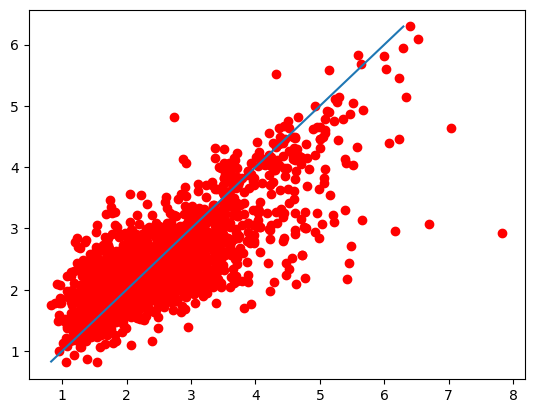

In [11]:
with torch.no_grad():
    inputs = torch.tensor(x_test.values).float()
    outputs = model(inputs).squeeze(-1)

import matplotlib.pyplot as plt

max_val = max(outputs.max(), outputs.max())
min_val = min(y_test.min(), y_test.min())
plt.plot([[min_val], [max_val]], [[min_val], [max_val]])
plt.scatter(y_test, outputs, color='r')

In [14]:
from sklearn.metrics import r2_score

f"{r2_score(y_test, outputs)=} {sqrt(mean_squared_error(y_test, outputs))=}"

'r2_score(y_test, outputs)=0.6164092926472113 sqrt(mean_squared_error(y_test, outputs))=0.5524158458268564'